<a href="https://colab.research.google.com/github/ekomissarov/data-analysis/blob/main/15_mice_and_people.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

based on - https://github.com/FUlyankin/matstat-AB/blob/main/week09_hypo/10_13_python_mouse_and_man.ipynb

In [1]:

#@title importing libraries
from scipy import stats
import statsmodels as sts

from google.colab import drive
import pandas as pd
import numpy as np
import time
from datetime import date, datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px


plt.style.use('dark_background')

def display_df(df=None):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

In [2]:
#@title mounting Google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#@title reading original csv
df = pd.read_csv('gdrive/MyDrive/public_data/mouse.csv', sep='\t')
df.head()

,STUDY,AGE,GENDER,DECISION,DEO1,DEO2,DEO3,DEO4,DEO5,DEO6,...,AE,MOUSE1,MOUSE2,MOUSE3,MOUSE,DOUBT,OTHERCHOICE,UNCOMFORTABLE,NOSHOCK,RT
0,1,38,1,NaN,2,2,2,1,2,2,...,5.000000,6.0,5.0,5.0,5.333333,NaN,NaN,NaN,NaN,NaN
1,1,22,1,NaN,1,2,2,1,2,1,...,5.727273,5.0,6.0,6.0,5.666667,NaN,NaN,NaN,NaN,NaN
2,1,39,1,NaN,1,1,3,5,3,1,...,5.545455,6.0,6.0,6.0,6.000000,NaN,NaN,NaN,NaN,NaN
3,1,21,0,1.0,2,3,3,3,3,2,...,5.136364,4.0,7.0,7.0,6.000000,2.0,0.0,6.0,80.0,9.212427
4,1,20,0,1.0,4,2,2,2,2,2,...,4.181818,4.0,6.0,6.0,5.333333,4.0,0.0,6.5,75.0,17.071711


*  STUDY: какую проблему вагонетки решал человек если реальную,
если на бумаге
*  AGE: возраст респондента
*  GENDER: пол респондента
*  DECISION: решение дилеммы (жать на кнопу / не жать)
*  RT: время, которое респондент потратил, чтобы нажать на кнопку

#Доля и нажатие на кнопку

In [4]:
# удалим пропуски для тех, кто не решил дилемму
df.dropna(subset=['DECISION'], inplace=True)

#H0 - Набумаге и вреальности жмут на кнопку одинаково часто
paper = df[df['STUDY'] == 2].DECISION.values
real = df[df['STUDY'] == 1].DECISION.values

In [5]:
def asy_mean_test(mean_hat, std_hat, mu_0=0,
                   alpha=0.05, alternative='two-sided', margin=3):

    z_obs = (mean_hat - mu_0)/std_hat

    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)

        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))

    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))


    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="green")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]

    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]

        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin,
                 h*y_max, round(statistic, 2), color=color, fontsize=16)

        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

    return p_value


In [6]:
paper.mean(), real.mean()

(0.7469879518072289, 0.8645833333333334)

In [7]:
alpha = 0.05                                       # уровень значимости = 5%
n1,n2 = paper.size, real.size                      # размеры выборок
m1,m2 = paper.sum(), real.sum()                    # число успехов

p1, p2 = real.mean(), paper.mean()                 # точеные оценки долей
diff = p1 - p2                                     # разность долей

P = (m1 + m2)/(n1 + n2)
diff_std = np.sqrt(P*(1 - P)*(1/n1 + 1/n2))        # стандартное отклонение разности

z_obs = diff/diff_std                              # наблюдаемое значение статистики
z_crit = stats.norm.ppf(1 - alpha/2)               # критическое значение статистики

print(f'{z_obs:.3} не попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза отвергается')


2.38 не попадает в (-1.96 , 1.96) => Нулевая гипотеза отвергается


0.017402155611556003

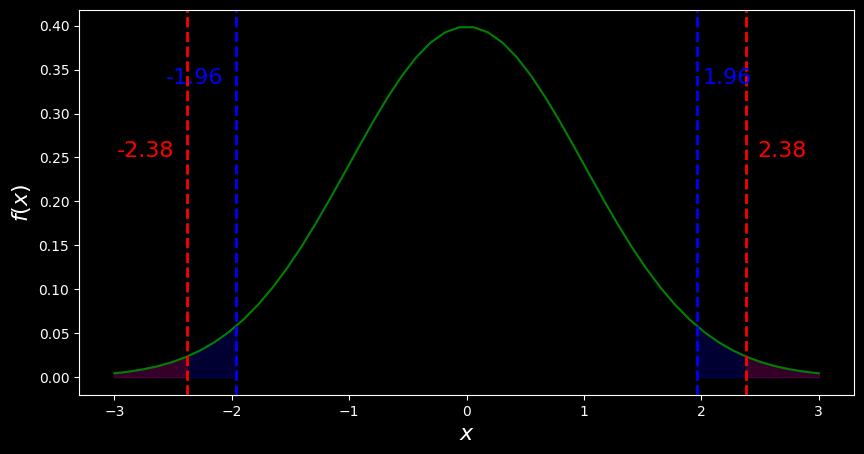

In [8]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='two-sided')

0.991298922194222

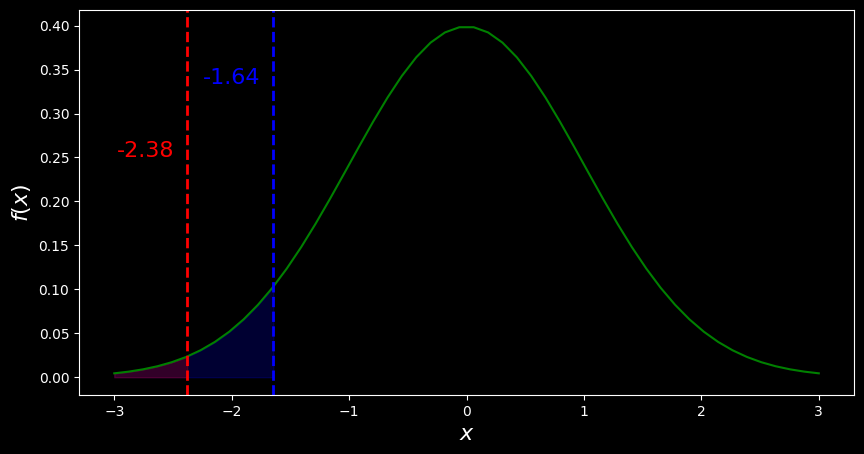

In [9]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='less')

In [10]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                                       # уровень значимости = 5%
n_obs = paper.size, real.size                      # размеры выборок
m_obs = paper.sum(), real.sum()                    # число успехов

z_obs, p_val =  proportions_ztest(m_obs, n_obs, value=0,
                                  alternative='smaller')

print(f"Наблюдаемое значение: {z_obs:.3}")
print(f"P-значение: {p_val:.3}")
#гипотеза о том, что на кнопку жмут одинаково часто отвергается. В реальности на кнопку жмут чаще.

Наблюдаемое значение: -2.38
P-значение: 0.0087


#Среднеe и тормознутость в принятии решения

In [14]:
# Асимптотический критерий
# H0: mu <= 5
# Ha: mu > 5
x = df['RT'].dropna().values         # выборка

alpha = 0.05                         # уровень значимости = 5%
n = x.size                           # размер выборки
mu = x.mean()                        # среднее значение
std = x.std(ddof=1)/np.sqrt(n)       # стандартное отклонение

z_obs = (mu - 5)/std                 # наблюдаемое значение статистики
z_crit = stats.norm.ppf(1 - alpha)   # критическое значение статистики

print(f'Наблюдаемое значение {z_obs:.4} больше критического {z_crit:.3} => нулевая гипотеза отвергается')


Наблюдаемое значение 12.97 больше критического 1.64 => нулевая гипотеза отвергается


0.0

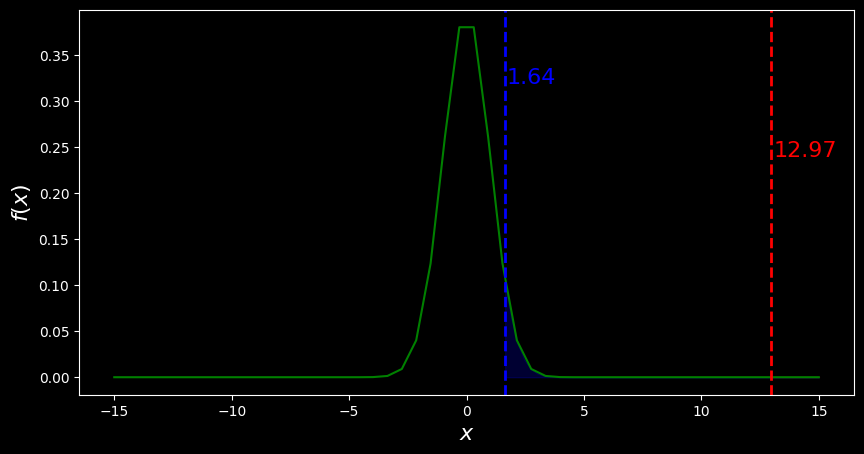

In [12]:
asy_mean_test(mu, std, mu_0=5, alpha=0.05,
              margin=15, alternative='larger')



In [15]:
from statsmodels.stats.weightstats import ztest

z_obs, p_val = ztest(x, value=5, alternative='larger')

print(f"Наблюдаемое значение: {z_obs:.7}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение: 12.9749
P-значение: 8.49e-39


In [16]:
#точный тест
t_obs = (mu - 5)/std                     # наблюдаемое значение статистики
t_crit = stats.t(n - 1).ppf(1 - alpha)   # критическое значение статистики

print(f'Наблюдаемое значение {t_obs:.4} больше критического {t_crit:.4} => нулевая гипотеза отвергается')


Наблюдаемое значение 12.97 больше критического 1.654 => нулевая гипотеза отвергается


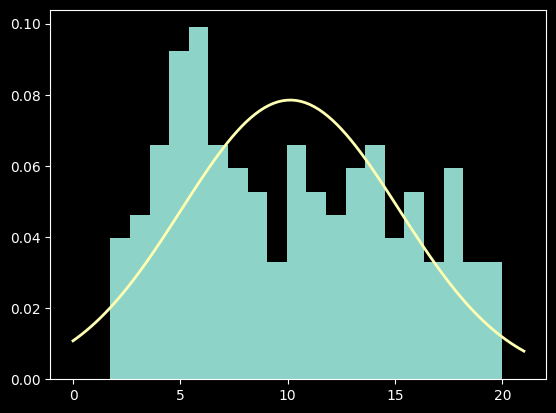

In [17]:
plt.hist(x, density=True, bins=20)

xs = np.linspace(0,21,100)
pdf = stats.norm(x.mean(), x.std(ddof=1)).pdf(xs)
plt.plot(xs, pdf, lw=2);

In [18]:
#нельзя пользоваться t-тестом так как выборка пришла не из нормального распределения
#тест Колмогорова-Смирнова на нормальность выборки
stats.kstest(x, 'norm', args=(df['RT'].mean(), df['RT'].std(ddof=1)))

KstestResult(statistic=0.10581791163988818, pvalue=0.045074232278964566, statistic_location=6.683372, statistic_sign=1)

#Сравнение тормознутости

In [19]:
men = df[(df['GENDER'] == 1)]['RT'].dropna().values
women = df[(df['GENDER'] == 0)]['RT'].dropna().values
men


array([ 9.827884, 10.14303 ,  7.447534,  3.900421,  6.257604,  8.35017 ,
        4.851916,  4.715757,  5.502697,  2.834183, 13.204802,  6.475876,
        8.112592, 11.550315, 15.830459, 13.966976, 16.467138,  5.847557,
       14.130201,  3.897559, 17.687435,  5.059607,  5.841785,  4.766936,
       10.962231,  2.934816, 18.404679,  5.461676, 13.413565,  7.79453 ,
       17.490769,  7.060378, 16.371952,  6.683372,  3.911258,  8.673753,
       15.396327,  4.671044,  4.104334, 12.423375,  9.657467,  8.533418,
       11.257031,  2.746188, 12.626013,  5.015116,  6.508459,  6.378889,
        5.775246, 20.      ,  3.16293 , 18.733759, 11.464392, 14.289954,
        4.844785, 10.858654, 20.      ])

In [20]:
men.mean(), women.mean()


(9.373347263157894, 10.505521238532111)

In [26]:
#в данных нет нормальности. Поэтому используем асимптотический тест
#H0: скорость нажания на кнопки одинаковая
#Ha: женщины медленнее (тратят больше времени)

alpha = 0.05                                                    # уровень значимости = 5%
nx, ny = women.size, men.size                                   # размер выборок

diff = women.mean() - men.mean()                                # разность средних
diff_std = np.sqrt(women.var(ddof=1)/nx + men.var(ddof=1)/ny)   # стандартное отклонение

z_obs = diff/diff_std                                           # наблюдаемое значение
z_crit = stats.norm.ppf(1 - alpha)                              # критическое значение

print(f'Наблюдаемое значение {z_obs:.5} меньше критического {z_crit:.3} => нулевая гипотеза не отвергается')
#Асимптотический тест для разных дисперсий в statsmodels не реализован. Есть только для равных.


Наблюдаемое значение 1.376 меньше критического 1.64 => нулевая гипотеза не отвергается


0.08441634419903932

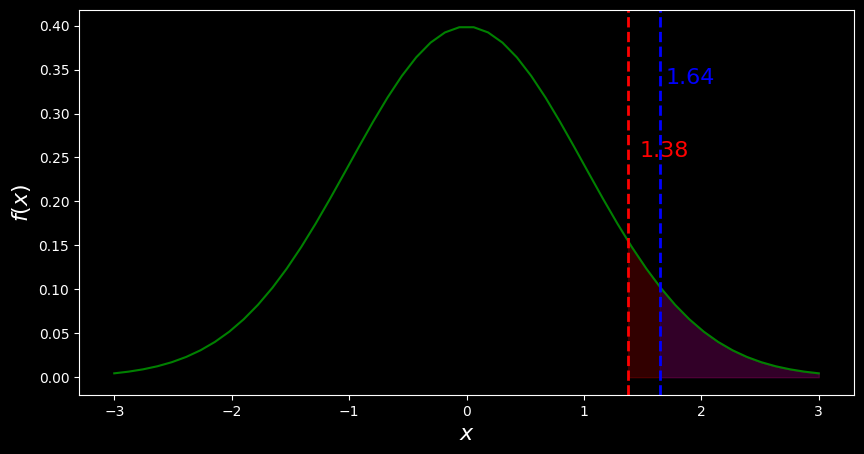

In [27]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger')

In [25]:
#Приведём ниже код, который мы бы использовали, если бы с нормальностью выборки всё бы было хорошо.
#Тест Стьюдента (неизвестные равные дисперсии)
alpha = 0.05                                                    # уровень значимости = 5%
nx, ny = women.size, men.size                                   # размер выборок
diff = women.mean() - men.mean()                                # разность средних

diff_var = ((nx - 1)*women.var(ddof=1) + (ny - 1)*men.var(ddof=1))/(nx + ny - 2)
diff_std = np.sqrt(diff_var/nx + diff_var/ny)                   # стандартное отклонение

t_obs = diff/diff_std                                           # наблюдаемое значение
t_crit = stats.t(df = nx + ny - 2).ppf(1 - alpha)               # критическое значение

print(f'Наблюдаемое значение {t_obs:.3} меньше критического {t_crit:.3} => нулевая гипотеза не отвергается')


Наблюдаемое значение 1.37 меньше критического 1.65 => нулевая гипотеза не отвергается


In [23]:
#То же самое средствами statsmodels
from statsmodels.stats.weightstats import ttest_ind

t_obs, p_val, _ = ttest_ind(women, men, value=0, alternative='larger')

print(f"Наблюдаемое значение: {t_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение: 1.37
P-значение: 0.0868


In [28]:
#Тест Уэлча (неизвестные разные дисперсии)
alpha = 0.05                                                    # уровень значимости = 5%
nx, ny = women.size, men.size                                   # размер выборок

diff = women.mean() - men.mean()                                # разность средних
diff_std = np.sqrt(women.var(ddof=1)/nx + men.var(ddof=1)/ny)   # стандартное отклонение

t_obs = diff/diff_std                                           # наблюдаемое значение

# число степеней свободы
u = (women.var(ddof=1) / nx + men.var(ddof=1) / ny) ** 2
d = (women.var(ddof=1)**2) / (nx**2 * (nx - 1)) + (men.var(ddof=1)**2) / (ny**2 * (ny - 1))
nu =  u/d

t_crit = stats.t(nu).ppf(1 - alpha)                             # критическое значение

print(f'Наблюдаемое значение {t_obs:.3} меньше критического {t_crit:.3} => нулевая гипотеза не отвергается')


Наблюдаемое значение 1.38 меньше критического 1.66 => нулевая гипотеза не отвергается


In [29]:
women.std(ddof=1), men.std(ddof=1)

(5.103972224167936, 4.996830829492463)

In [30]:
nx, ny # направление знака между наблюдениями соотвествует знаку между дисперсиями
# если бы выборки были бы нормальнымы можно было бы применять

(109, 57)

In [33]:
#То же самое средствами statsmodels
from statsmodels.stats.weightstats import ttest_ind

# usevar по умолчанию думает, что дисперсии одинаковые
t_obs, p_val, _ = ttest_ind(women, men, value=0,
                            alternative='larger', usevar='unequal')

print(f"Наблюдаемое значение: {t_obs:.3}")
print(f"P-значение: {p_val:.3}")

Наблюдаемое значение: 1.38
P-значение: 0.0857


In [ ]:
#Эмпатия, сравнение дисперсий



Перед экспериментом каждый участник проходил психологический тест. Для каждого человека рассчитывалось довольно большое число параметров, описывающих его психотип. Например, в колонках EC находится оценка способности человека к эмпатии (Empathic concern), в колонке AE находится оценка эмпатии человека к животным.



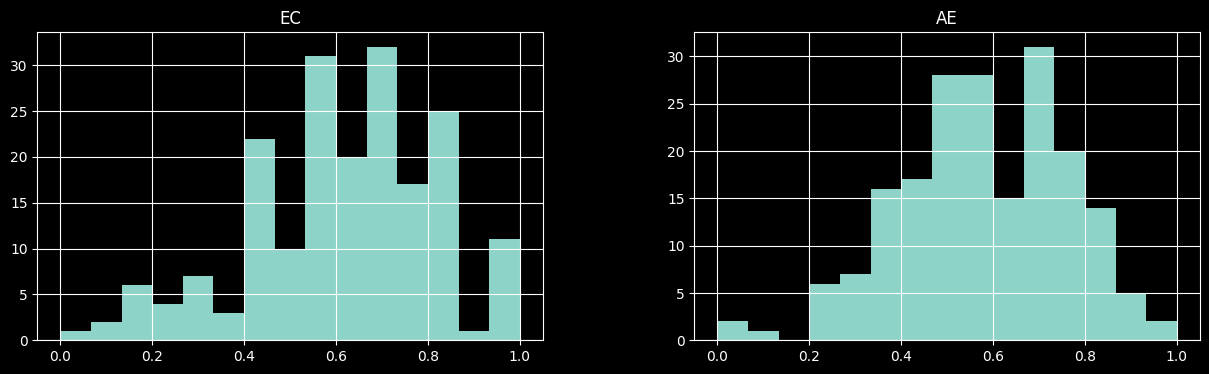

In [34]:
#масштабируем к шкале [0,1]
df['EC'] = (df['EC'] - df['EC'].min())/(df['EC'].max() - df['EC'].min())
df['AE'] = (df['AE'] - df['AE'].min())/(df['AE'].max() - df['AE'].min())

df[['EC', 'AE']].hist(bins=15, figsize=(15,4));



In [35]:
#Правда ли, что неоднородность людей в плане их эмпатии к животным намного выше неоднородности в плане обычной эмпатии?
#H0: дисперсии равны
#Ha: дисперсия для животных выше

ec = df['EC'].dropna().values
ae = df['AE'].dropna().values

ec.mean(), ae.mean()


(0.6190814394131477, 0.5798980496933709)

In [36]:
ec.var(), ae.var()

(0.04247637731538298, 0.032046916944347074)

In [37]:
alpha = 0.05                             # уровень значимости = 5%
nx, ny = ec.size, ae.size                # размер выборок

F_obs = ec.var()/ae.var()                # наблюдаемое значение

f_rv = stats.f(nx - 1, ny - 1)
F_crit = f_rv.ppf(1 - alpha/2)           # критическое значение

print(f'Наблюдаемое значение {F_obs:.5} меньше критического {F_crit:.5} => нулевая гипотеза не отвергается')


Наблюдаемое значение 1.3254 меньше критического 1.3291 => нулевая гипотеза не отвергается
